In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

<IPython.core.display.Javascript object>


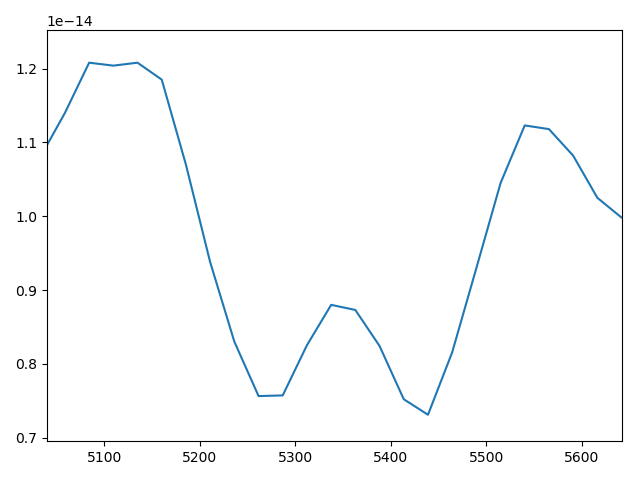

In [234]:
# read spec data
z = 0.0094
spec = '/Users/adamamiller/astronomy/ZTF/SN19yvq/data/spectra/ZTF19adcecwu_20200115_P60_v1.ascii'

spec_df = pd.read_csv(spec, comment='#', delim_whitespace=True, header=None)
wv = spec_df[0].values
fl = spec_df[1].values

plt.figure()
plt.plot(wv/(1+z), fl)
plt.tight_layout()

In [324]:
def lnlike_gaussian_abs(theta, vel_rf, norm_flux, 
                        delta_vel_components=[], flux_unc = 1):
    
    mean_vel, lnvar, amplitude = theta
    var_vel = np.exp(lnvar)
    
#     model_flux = np.ones_like(vel_rf)
    model_flux = 1 + amplitude/np.sqrt(2*np.pi*var_vel)*np.exp(-0.5*(vel_rf - mean_vel)**2/var_vel)
    if len(delta_vel_components) > 0:
        for delta_vel in delta_vel_components:
            model_flux += amplitude/np.sqrt(2*np.pi*var_vel)*np.exp(-0.5*(vel_rf - (mean_vel-delta_vel))**2/var_vel)
    lnl = - 0.5*len(model_flux)*np.log(2*np.pi) - np.sum(np.log(flux_unc)) -0.5*np.sum((norm_flux - model_flux)**2 / flux_unc**2) 
    
    return lnl

def neg_lnlike_gaussian_abs(theta, vel_rf, norm_flux, 
                        delta_vel_components=[], flux_unc = 1):
    lnl = lnlike_gaussian_abs(theta, vel_rf, norm_flux, 
                              delta_vel_components=delta_vel_components, 
                              flux_unc = flux_unc)
    return -1*lnl

In [316]:
def divide_continuum(lambda_rf, flux, blue_continuum, red_continuum):
    '''Divide out linear continuum factor'''
    
    linear_continuum = lambda slope, wave, wave0, flux0: slope*(wave - wave0) + flux0
    
    slope = (blue_continuum[1]-red_continuum[1])/(blue_continuum[0] - red_continuum[0])
    norm_flux = flux/linear_continuum(slope, lambda_rf, blue_continuum[0], blue_continuum[1])
    
    return norm_flux

In [317]:
def velocity_rf(lambda_rf, lambda_0):
    '''convert rest-frame wavelength to relative velocity'''
    c = 2.99792458e5
    v = c*((lambda_rf/lambda_0)**2 - 1)/((lambda_rf/lambda_0)**2 + 1)
    
    return v

In [306]:
[1.         0.99999998 0.99999978 0.99999747 0.99997724 0.99983873
 0.99910357 0.99602195 0.98594842 0.96045703 0.91018599 0.83522302
 0.75437705 0.70047404 0.69706165 0.73832482 0.7893479 ]

array([0.98030908, 0.94557024, 0.88035884, 0.78858788, 0.69925743,
       0.65323553, 0.67063837, 0.72960222, 0.77997736, 0.78188724,
       0.73470666, 0.67605719, 0.65373827, 0.69069028, 0.77226529,
       0.86226622, 0.93141983])


[0.98362758 0.94920981 0.87960104 0.77883879 0.68387619 0.64482507
 0.68011199 0.75530106 0.80850533 0.79836682 0.73277689 0.66298293
 0.64557246 0.69889333 0.79479423 0.88781962 0.95060352]

array([0.80238401, 0.80453494, 0.74343484, 0.66962103, 0.6462303 ,
       0.6983928 , 0.7969628 , 0.89276385, 0.95558297, 0.98550998,
       0.99630861, 0.99926205, 0.99988405, 0.99998553, 0.99999859,
       0.99999989, 0.99999999])

SyntaxError: invalid syntax (<ipython-input-306-7e3f235089ba>, line 1)

In [319]:
theta = (-10000, 16, -800)
# theta = [-2.20144517e+04,  1.58635773e+01, -8.71247839e+02]

line_region = np.where((wv/(1+z) > 5115) & 
                       (wv/(1+z) < 5552))
lnlike_gaussian_abs(theta, vel_rf[line_region], 
                        norm_flux[line_region], 
                        delta_vel_components=[velocity_rf(5647.033, 5639.972),
                                              velocity_rf(5647.033, 5606.151),
                                              velocity_rf(5647.033, 5473.620),
                                              velocity_rf(5647.033, 5453.828),
                                              velocity_rf(5647.033, 5432.815)])

[0.98825282 0.96493335 0.91687035 0.84168809 0.75757424 0.69976759
 0.69584927 0.73969008 0.79234887 0.81131396 0.78248659 0.72893696
 0.69357166 0.70732861 0.76874587 0.84969309 0.91952836]


-15.64458715983075

In [262]:
norm_flux = divide_continuum(wv/(1+z), fl, (5105, 1.2e-14), (5552,1.11e-14))

<IPython.core.display.Javascript object>


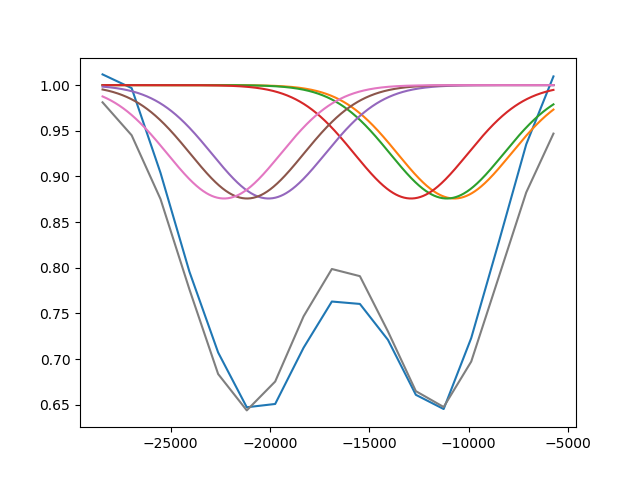

In [331]:
theta = (-10500, 16, -900)
theta = [-10717.26509886,     15.90859163,   -886.24646543]
mean, lnvar, amp = theta
var = np.exp(lnvar)

plt.figure()
plt.plot(vel_rf[line_region], norm_flux[line_region])
vel_grid = np.linspace(vel_rf[line_region][0], 
                        vel_rf[line_region][-1], 
                        1000)
plt.plot(vel_grid, 1 + calc_gauss(vel_grid, mean, var, amp))
tot_flux = 1 + calc_gauss(vel_rf[line_region], mean, var, amp)
for delta_vel in [velocity_rf(5647.033, 5639.972),
                  velocity_rf(5647.033, 5606.151),
                  velocity_rf(5647.033, 5473.620),
                  velocity_rf(5647.033, 5453.828),
                  velocity_rf(5647.033, 5432.815)
                 ]:
    plt.plot(vel_grid, 1 + calc_gauss(vel_grid, mean-delta_vel, var, amp))
    tot_flux += calc_gauss(vel_rf[line_region], mean-delta_vel, var, amp)
plt.plot(vel_rf[line_region], tot_flux)

In [352]:
beta = -886*6/2.9979e5
5647*(1-np.sqrt((1+beta)/(1-beta)))

99.26265488616602

In [349]:
beta = .35*10000/2.9979e5
5647*(1-np.sqrt((1+beta)/(1-beta)))

-66.31719730695781

In [290]:
-0.5*np.sum((norm_flux[line_region] - tot_flux)**2)

-0.010909729101504822

In [322]:
def calc_gauss(x, mean, var, amp):
    return amp/np.sqrt(2*np.pi*var)*np.exp(-0.5*(x-mean)**2/var)

In [340]:
from scipy.optimize import minimize

vel_rf = velocity_rf(wv/(1+z), 5647.033)
ml_res = minimize(neg_lnlike_gaussian_abs, (-10000, 10, -1000), method='Powell', # Powell method does not need derivatives
                      args=(vel_rf[line_region], norm_flux[line_region], 
                            [velocity_rf(5647.033, 5639.972),
                             velocity_rf(5647.033, 5606.151),
                             velocity_rf(5647.033, 5473.620),
                             velocity_rf(5647.033, 5453.828),
                             velocity_rf(5647.033, 5432.815)
                            ]))

In [341]:
ml_res

   direc: array([[ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  1.        ,  0.        ],
       [-3.53115419, -0.00947407,  1.88406335]])
     fun: 16.005633110967864
 message: 'Optimization terminated successfully.'
    nfev: 76
     nit: 2
  status: 0
 success: True
       x: array([-1.01375668e+04,  9.68808842e+00, -9.28922392e+02])

In [185]:
beta = 2*ml_res.x[2]/2.99792458e5

(1 - np.sqrt((1+beta)/(1-beta)))*6371

173.33805610930207

## Build in OOP

In [342]:
class SpectrumSN():
    '''1D optical spectrum'''
    
    def __init__(self, wave, flux, z=0, flux_unc=0):
        self.wave = wave
        self.flux = flux
        self.lambda_rf = wave/(1+z)
        self.res_dict = {}
    
    def measure_vel_and_ew(self, blue_edge, red_edge,
                           fit_region = [],
                           guess = (-10000, 15, -1000),
                           lambda_0 = 6562.85,
                           line_name = 'Halpha',
                           delta_vel = []):
        '''Measure the velocity and equivalent width'''
        
        if len(fit_region) == 0:
            fit_region = [blue_edge[0], red_edge[0]]
            
        norm_flux = divide_continuum(self.lambda_rf, self.flux, 
                                     blue_edge, red_edge)
        v_rf = velocity_rf(self.lambda_rf, lambda_0)
        line = np.where((self.lambda_rf >= fit_region[0]) & 
                        (self.lambda_rf <= fit_region[1]))
        
        vel_fit = minimize(neg_lnlike_gaussian_abs, guess, method='Powell',
                           args=(v_rf[line], norm_flux[line], delta_vel))
        v_absorb = vel_fit.x[0]
        beta = vel_fit.x[2]*(len(delta_vel)+1)/2.99792458e5
        ew = lambda_0*(1-np.sqrt((1+beta)/(1-beta)))
        
        self.res_dict[line_name] = (v_absorb, ew)
    
    def si_6355(self, blue_edge, red_edge, 
                fit_region = [],
                guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                           fit_region = fit_region,
                           guess = guess,
                           lambda_0 = 6371.37,
                           line_name = 'Si6355',
                           delta_vel = [velocity_rf(6371.359, 6347.103)])
    
    def si_5972(self, blue_edge, red_edge, 
            fit_region = [],
            guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 5978.929,
                                line_name = 'Si5972',
                                delta_vel = [velocity_rf(5978.929, 5957.561)])
    def si_5669(self, blue_edge, red_edge, 
            fit_region = [],
            guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 5669.562,
                                line_name = 'Si5669',
                                delta_vel = [])

    def si_5048(self, blue_edge, red_edge, 
            fit_region = [],
            guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 5055.981,
                                line_name = 'Si5048',
                                delta_vel = [velocity_rf(5055.981, 5041.026)])

    def si_4130(self, blue_edge, red_edge, 
                fit_region = [],
                guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 4130.893,
                                line_name = 'Si4130',
                                delta_vel = [velocity_rf(4130.893, 4128.067)])

    def s_5500(self, blue_edge, red_edge, 
                fit_region = [],
                guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 5647.033,
                                line_name = 'S5500',
                                delta_vel = [velocity_rf(5647.033, 5639.972),
                                             velocity_rf(5647.033, 5606.151),
                                             velocity_rf(5647.033, 5473.620),
                                             velocity_rf(5647.033, 5453.828),
                                             velocity_rf(5647.033, 5432.815)
                                            ])

In [355]:
minus13 = SpectrumSN(wv, fl, z=z)

In [356]:
minus13.si_6355((5830, 1.01e-14), (6288,9.84e-15))
# ,
#                 guess = (-15893.41748703,     16.70304233,  -4133.73835717))

In [357]:
minus13.res_dict

{'Si6355': (-14897.383572406578, 172.95954021820506)}

In [358]:
minus13.s_5500((5115, 1.2e-14), (5552,1.11e-14))
# ,
#                 guess = (-10000,     15.,  -1000.73835717))

In [359]:
minus13.res_dict

{'S5500': (-10137.608230605018, 104.01147291101874),
 'Si6355': (-14897.383572406578, 172.95954021820506)}